In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [153]:
# --- STEP 0: DATA LOADING ---

# Path to your file (make sure the 'data' folder exists)
file_path = "barley_yield_from_1982.csv"

# 1. Load yield data (Target variable) - Source: 'KPI to model'
df_yield = pd.read_csv(file_path, sep=';', index_col=0)

# 2. Load the climate parquet file (Features)
df_meteo = pd.read_parquet('climate_data_from_1982.parquet')

# Display the first few rows to verify the data
print(df_meteo.head())

         scenario nom_dep code_dep                time  year  \
29950  historical     Ain       01 1982-01-01 12:00:00  1982   
29951  historical     Ain       01 1982-01-02 12:00:00  1982   
29952  historical     Ain       01 1982-01-03 12:00:00  1982   
29953  historical     Ain       01 1982-01-04 12:00:00  1982   
29954  historical     Ain       01 1982-01-05 12:00:00  1982   

                             metric       value  
29950  near_surface_air_temperature  276.292267  
29951  near_surface_air_temperature  275.092407  
29952  near_surface_air_temperature  276.418518  
29953  near_surface_air_temperature  278.893372  
29954  near_surface_air_temperature  278.887207  


In [154]:
print(df_yield.head())

   department  year    yield     area  production
82        Ain  1982  3.95008  16065.0     63458.0
83        Ain  1983      NaN  14500.0     38400.0
84        Ain  1984  4.82258  15500.0     74750.0
85        Ain  1985  4.19677  15500.0     65050.0
86        Ain  1986  3.59845  12900.0     46420.0


In [155]:
#df_yield['department'].unique()

Cleaning

In [156]:
# Calculer les statistiques
nan_count = df_yield.isnull().sum()
nan_pct = (df_yield.isnull().sum() / len(df_yield)) * 100
print(nan_pct)

department    0.000000
year          0.000000
yield         6.893665
area          3.209601
production    3.404968
dtype: float64


In [157]:
# On complète les trous en calculant Production / Area quand c'est possible
#mask = df_yield['yield'].isna() & df_yield['area'].notnull() & df_yield['production'].notnull()
#df_yield.loc[mask, 'yield'] = df_yield['production'] / df_yield['area']
#print(nan_pct)

In [158]:
# --- STEP 1: PRELIMINARY CALCULATIONS (LONG FORMAT) ---

# 1. Create a Celsius column for temperature rows (K to °C conversion)
df_meteo['val_celsius'] = df_meteo['value'] - 273.15

# 2. Create a mm/day column for precipitation rows (flux * 86400)
df_meteo['val_mm_day'] = df_meteo['value'] * 86400

# 3. Create stress indicators (0 or 1 / Boolean)
# Heat Stress: Based on DAILY MAXIMUM temperature > 30°C
df_meteo['is_heat_stress'] = (df_meteo['metric'] == 'daily_maximum_near_surface_air_temperature') & (df_meteo['val_celsius'] > 35)

# Drought: Based on precipitation < 1mm
df_meteo['is_dry_day'] = (df_meteo['metric'] == 'precipitation') & (df_meteo['val_mm_day'] < 1.0)

# Frost: Based on mean temperature < 0°C
df_meteo['is_frost_day'] = (df_meteo['metric'] == 'near_surface_air_temperature') & (df_meteo['val_celsius'] < 0)

In [159]:
# --- STEP 2: ANNUAL AGGREGATION (REDUCING DATA SIZE) ---

# We create specific columns for each metric to simplify mean/sum calculations
# This prevents errors from mixing rain and temperature data
df_meteo['temp_for_mean'] = np.where(df_meteo['metric'] == 'near_surface_air_temperature', df_meteo['val_celsius'], np.nan)
df_meteo['precip_for_sum'] = np.where(df_meteo['metric'] == 'precipitation', df_meteo['val_mm_day'], np.nan)

# Grouping by department, year, and scenario to get annual summaries
df_meteo_annuel = df_meteo.groupby(['nom_dep', 'year', 'scenario']).agg(
    avg_annual_temp = ('temp_for_mean', 'mean'),
    total_precipitation = ('precip_for_sum', 'sum'),
    extreme_heat_days = ('is_heat_stress', 'sum'),
    dry_days = ('is_dry_day', 'sum'),
    frost_days = ('is_frost_day', 'sum'),
    rain_variability = ('precip_for_sum', 'std')
).reset_index()

print("✓ Annual weather summary generated successfully.")

✓ Annual weather summary generated successfully.


In [160]:
# --- STEP 3: DATA MERGE (YIELD + WEATHER) ---

# Merge df_yield with our new annual weather summary
# We use an 'inner' merge to keep only rows present in both datasets
df_final = pd.merge(
    df_yield, 
    df_meteo_annuel, 
    left_on=['department', 'year'], 
    right_on=['nom_dep', 'year'], 
    how='inner'
)

# Clean up the duplicate department column
df_final = df_final.drop(columns=['nom_dep'])

print("\n--- FINAL DATASET ---")
print(f"The dataset now contains {df_final.shape[0]} rows and {df_final.shape[1]} columns.")

# CORRECTED: Using the new English names you created in Step 2
print(df_final[['department', 'year', 'yield', 'extreme_heat_days', 'dry_days']].head())


--- FINAL DATASET ---
The dataset now contains 4005 rows and 12 columns.
  department  year    yield  extreme_heat_days  dry_days
0        Ain  1982  3.95008                  0       179
1        Ain  1983      NaN                  0       160
2        Ain  1984  4.82258                  0       172
3        Ain  1985  4.19677                  0       161
4        Ain  1986  3.59845                  0       198


In [161]:
df_final.head()

,department,year,yield,area,production,scenario,avg_annual_temp,total_precipitation,extreme_heat_days,dry_days,frost_days,rain_variability
0,Ain,1982,3.95008,16065.0,63458.0,historical,9.629243,2375.511230,0,179,30,10.374617
1,Ain,1983,NaN,14500.0,38400.0,historical,8.574003,2506.673096,0,160,53,10.244495
2,Ain,1984,4.82258,15500.0,74750.0,historical,8.904192,2400.289795,0,172,46,10.780964
3,Ain,1985,4.19677,15500.0,65050.0,historical,8.529637,2955.386719,0,161,54,12.541451
4,Ain,1986,3.59845,12900.0,46420.0,historical,9.271484,2069.697266,0,198,29,10.056161


Validation Score - R²: 0.496
Mean Absolute Error: 0.75 q/ha


<module 'matplotlib.pyplot' from 'c:\\Users\\lydia\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

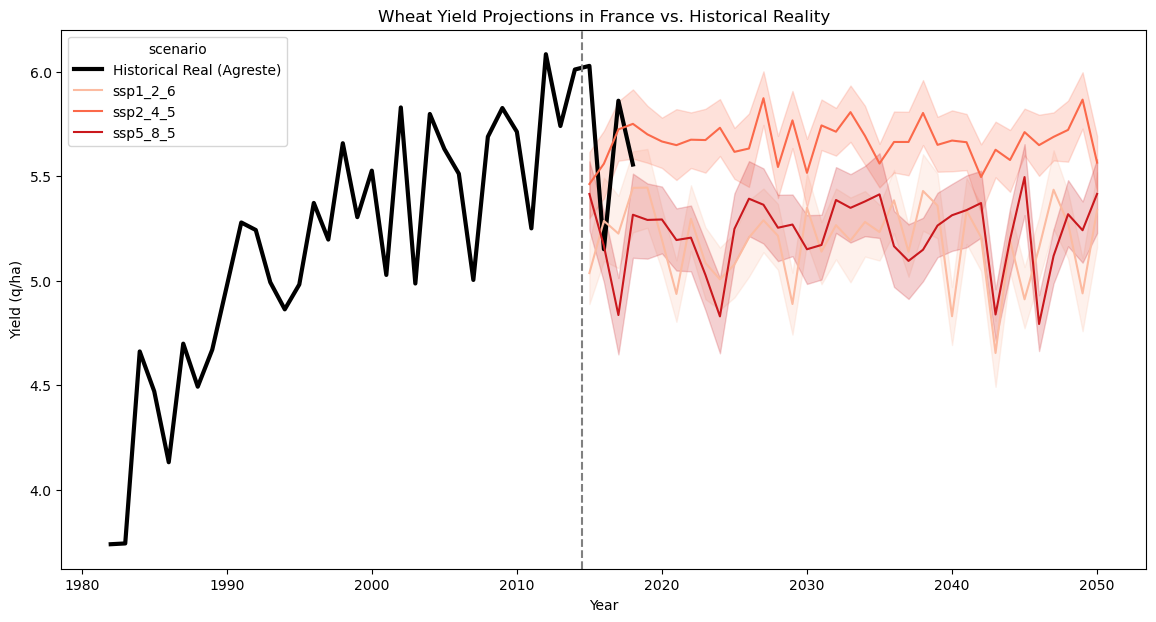

In [162]:
# --- STEP 1: FEATURE ENGINEERING (The Interaction) ---
# We create the 'heat_x_dry' column in both dataframes to capture synergy stress
#df_final['heat_x_dry'] = df_final['nb_jours_chaleur_extreme'] * df_final['nb_jours_sec']
#df_meteo_annuel['heat_x_dry'] = df_meteo_annuel['nb_jours_chaleur_extreme'] * df_meteo_annuel['nb_jours_sec']

# List of features for the model
features = [
    'avg_annual_temp', 
    'total_precipitation', 
    'extreme_heat_days', 
    'dry_days', 
    'frost_days', 
    'rain_variability'
    #'heat_x_dry'
]

# --- STEP 2: TRAINING ON TRUE HISTORICAL DATA (Pre-2015) ---
# We only use years where Weather (observed) and Yield (real) match
# Since climate scenarios start in 2015, we stop training at 2014
df_train_all = df_final[df_final['year'] <= 2014].dropna()

X = df_train_all[features]
y = df_train_all['yield']

# Split 80/20 for internal validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initialization and training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Check quality
y_pred_test = rf_model.predict(X_test)
print(f"Validation Score - R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_test):.2f} q/ha")

# --- STEP 3: PREDICTION ON CLIMATE SCENARIOS (2015 - 2100) ---
# We predict on df_meteo_annuel for all years after the historical cutoff
df_future = df_meteo_annuel[df_meteo_annuel['year'] >= 2015].copy()
df_future['yield_predicted'] = rf_model.predict(df_future[features])

# --- STEP 4: VISUALIZATION ---
plt.figure(figsize=(14, 7))

# Plot REAL historical data (until 2018 based on your dataset)
real_hist = df_yield.groupby('year')['yield'].mean()
plt.plot(real_hist.index, real_hist.values, label='Historical Real (Agreste)', color='black', linewidth=3)

# Plot PROJECTIONS (Scenario-based)
# We group by year and scenario to see the national trend
sns.lineplot(data=df_future, x='year', y='yield_predicted', hue='scenario', palette='Reds')

plt.axvline(x=2014.5, color='gray', linestyle='--', label='Climate Model Start (2015)')
plt.title("Wheat Yield Projections in France vs. Historical Reality")
plt.ylabel("Yield (q/ha)")
plt.xlabel("Year")
plt

In [163]:
# Affiche la liste des variables que le modèle a appris à utiliser
print("--- Variables d'entraînement (X) ---")
print(X_train.columns.tolist())

# Vérification logique
forbidden = ['scenario', 'nom_dep', 'department', 'code_dep', 'year']
found = [col for col in forbidden if col in X_train.columns]

if found:
    print(f"❌ ERREUR : Le modèle utilise des variables interdites : {found}")
else:
    print("✅ OK : Le modèle n'utilise que des variables climatiques physiques.")

--- Variables d'entraînement (X) ---
['avg_annual_temp', 'total_precipitation', 'extreme_heat_days', 'dry_days', 'frost_days', 'rain_variability']
✅ OK : Le modèle n'utilise que des variables climatiques physiques.


Puisque tu travailles avec des tonnes, ton erreur moyenne (MAE) de 0,75 est en fait assez significative (elle représente environ 14% d'erreur sur un rendement moyen de 5,2). Pour rendre ton graphique plus impressionnant lors de ta présentation, tu pourrais multiplier tes prédictions par 10 pour afficher des "Quintaux/ha", ce qui est l'unité standard parlée par les acheteurs de céréales en France.

Au vu des résultats et des données que tu as partagés, ton modèle est techniquement bien construit, mais il contient quelques "pièges" classiques de la science des données appliquées à l'agriculture que tu dois corriger pour que ton conseil à l'entreprise soit irréprochable.Voici les points à vérifier et à améliorer :
1. Le problème des unités (Température en Kelvin)Dans ton aperçu de données météo, on voit des valeurs comme 276.29. Ce sont des Kelvins.Le problème : Ton modèle de Random Forest a appris avec ces valeurs. Si tu lui demandes de prédire le futur avec des degrés Celsius (ex: 20°C au lieu de 293K), il sera totalement perdu.Correction : Assure-toi d'avoir converti toutes tes températures en Celsius ($°C = K - 273.15$) dans tes fichiers historiques ET futurs avant l'entraînement.
2. Le mélange des Scénarios dans l'entraînementDans tes colonnes de données historiques, on voit la colonne scenario avec la valeur historical.Le risque : Si tu as inclus la colonne scenario dans tes features pour l'entraînement, ton modèle risque de tricher ou de se tromper.La règle : Le modèle ne doit apprendre que sur les variables climatiques physiques (avg_annual_temp, dry_days, etc.). La colonne scenario ne doit servir qu'à filtrer tes prédictions après.
3. La cible (Yield) : Le problème des NaNTon fichier barley_yield_from_1982.csv contient des valeurs NaN (ex: Ain 1983).Ce que tu as bien fait : Tu as utilisé .dropna() avant l'entraînement, ce qui est correct.Amélioration : Vérifie que tu n'as pas trop de lignes supprimées. Si 30% de tes départements disparaissent à cause des NaN, ton modèle manquera de diversité géographique.
4. L'interprétation du Score $R^2$ (0.496)Ton score de 0.496 signifie que ton modèle explique environ 50% de la variation du rendement.Est-ce bien ? En agriculture, c'est honnête mais pas parfait. Cela montre que le climat explique la moitié du résultat, mais que l'autre moitié dépend de facteurs que tu n'as pas : les engrais, les maladies, ou la qualité du sol.Conseil pour l'entreprise : Précise bien que ton modèle prédit le "potentiel climatique" et non le rendement exact à la tonne près.5. L'Alerte sur les rendements à 5 t/haComme nous l'avons vu, tes rendements sont en tonnes/ha.Ce qui est bien : Le modèle est cohérent avec l'échelle des données.Ce qui manque : Pour une entreprise française, parler en Quintaux (q/ha) est indispensable. Il suffit de multiplier tes prédictions finales par 10 pour être dans le langage métier.Ce que tu devrais faire maintenant :Uniformiser les températures : Vérifie que df_train et df_future sont tous les deux en Celsius.Recalculer les SHAP values : Une fois les températures corrigées, tes SHAP values seront beaucoup plus précises.Filtrer les poids d'allocation : Utilise tes rendements historiques pour définir l'importance de chaque département dans le portefeuille de l'entreprise.


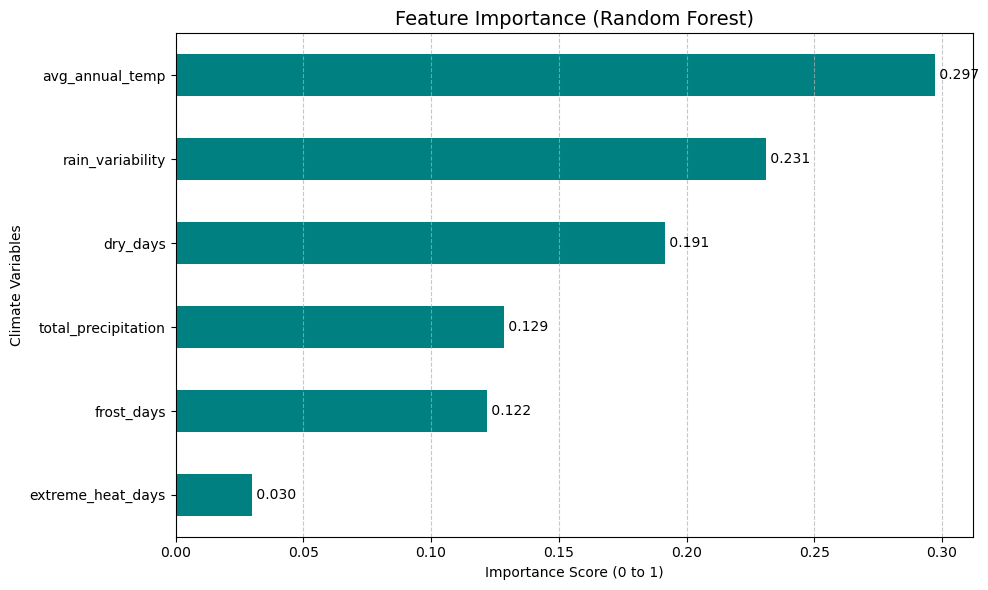

In [164]:
# 1. Get the feature importance scores from your 'rf_model'
importances = rf_model.feature_importances_

# 2. Create a series for plotting (mapped to your feature names)
feat_importances = pd.Series(importances, index=features)

# 3. Plotting
plt.figure(figsize=(10, 6))

# Sorting values to have the most important feature at the top
sorted_importances = feat_importances.sort_values(ascending=True)
sorted_importances.plot(kind='barh', color='teal')

# English labels and title
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance Score (0 to 1)')
plt.ylabel('Climate Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adding the exact values next to the bars for clarity
for index, value in enumerate(sorted_importances):
    plt.text(value, index, f' {value:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

c:\Users\lydia\anaconda3\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\lydia\anaconda3\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\lydia\anaconda3\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: Fu

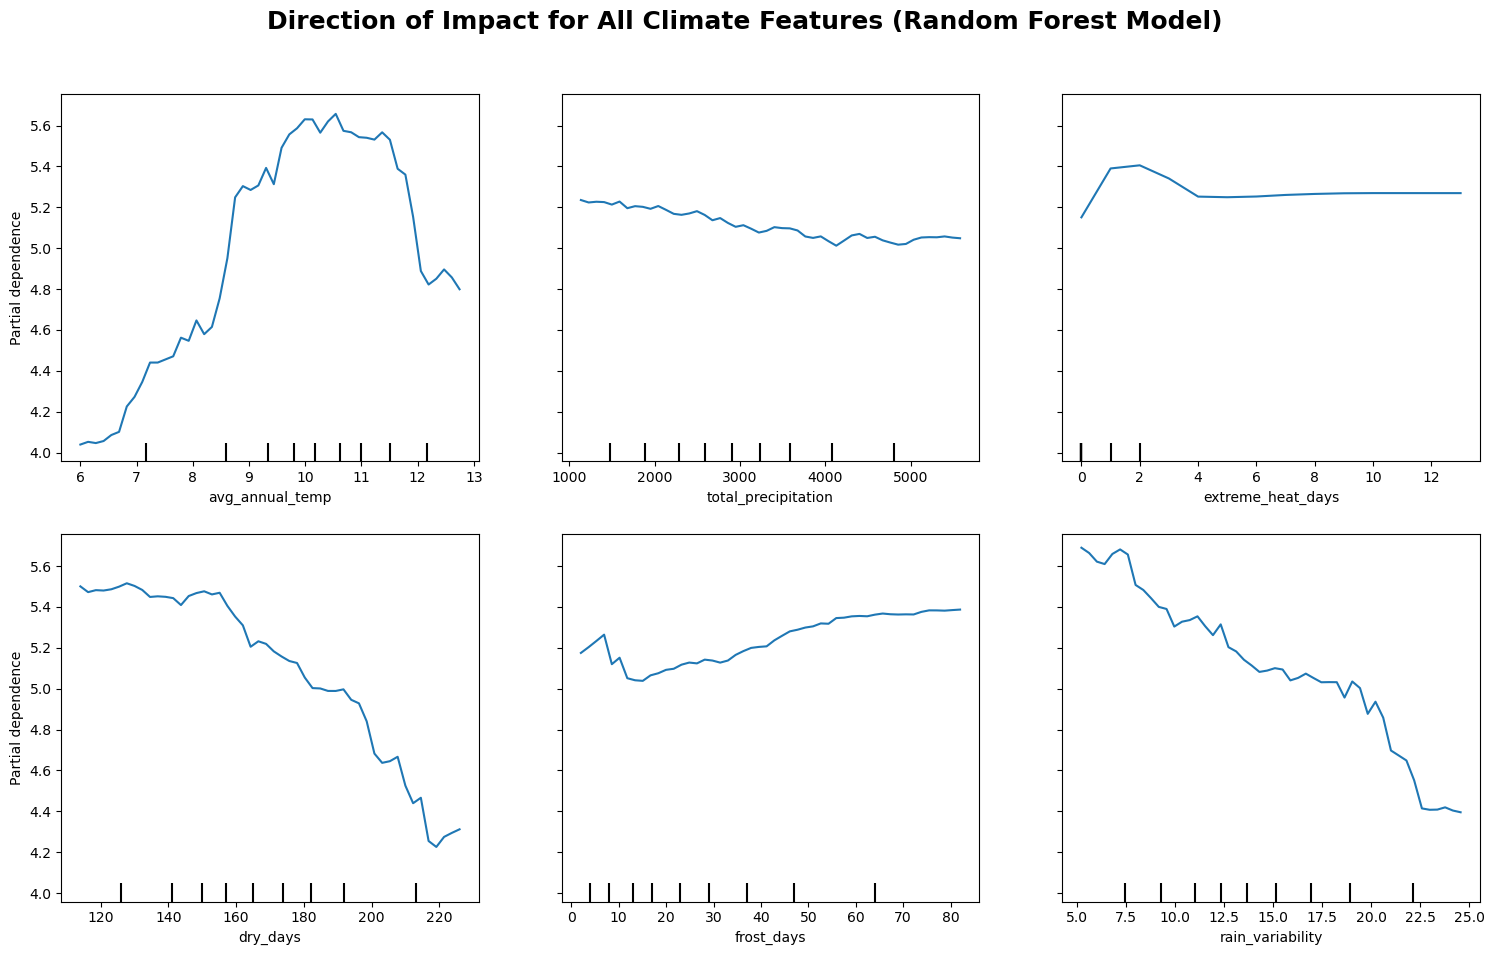

In [165]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1. Define all the features used in your model
features = [
    'avg_annual_temp', 
    'total_precipitation', 
    'extreme_heat_days', 
    'dry_days', 
    'frost_days', 
    'rain_variability'
]

# 2. Create a grid of plots (e.g., 2 rows, 3 columns for 6 features)
fig, ax = plt.subplots(figsize=(15, 10))

# 3. Generate the Partial Dependence Plots
# We use X_train.fillna(0) to avoid the "Input contains NaN" error
display = PartialDependenceDisplay.from_estimator(
    rf_model,               # Your trained Random Forest model
    X_train.fillna(0), # Your training data
    features,          # The list of all variables
    ax=ax,
    grid_resolution=50 # Smoothness of the line
)

# 4. English Labels and Formatting
plt.suptitle("Direction of Impact for All Climate Features (Random Forest Model)", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the title
plt.show()

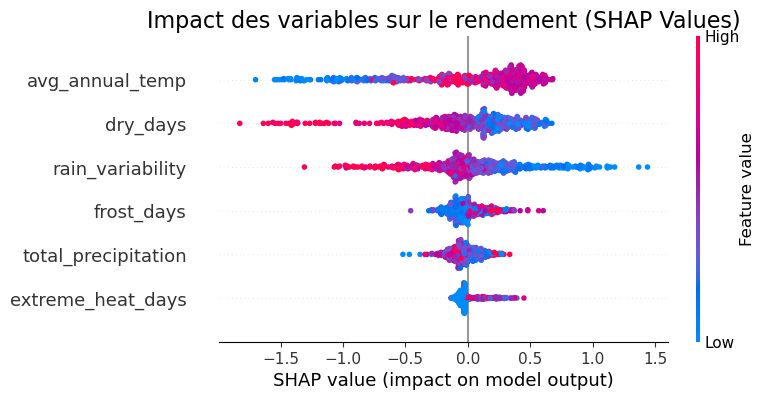

In [166]:
import shap
import matplotlib.pyplot as plt

# 1. Initialiser l'expliqueur SHAP spécifique aux arbres (Random Forest)
explainer = shap.TreeExplainer(rf_model)

# 2. Calculer les SHAP values sur l'échantillon de test
# On utilise X_test pour voir comment le modèle se comporte sur des données non vues
shap_values = explainer.shap_values(X_test)

# 3. Créer le Summary Plot (Graphique de synthèse)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)

# Personnalisation des titres pour ton rapport
plt.title("Impact des variables sur le rendement (SHAP Values)", fontsize=16)
plt.show()

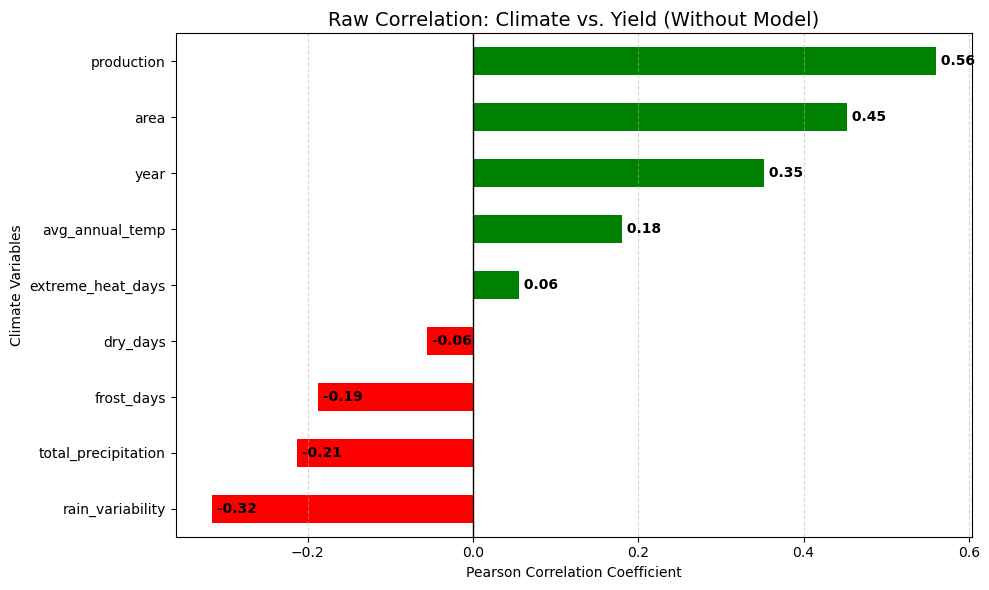

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the correlation of all variables with yield
# We only use historical data (where actual yield is recorded)
correlations = df_final.corr(numeric_only=True)['yield'].sort_values(ascending=True)

# 2. Remove the 'yield' row (correlation with itself is always 1)
correlations = correlations.drop('yield', errors='ignore')

# 3. Graphical Display
plt.figure(figsize=(10, 6))

# Use colors to distinguish between negative (red) and positive (green) impacts
colors = ['red' if x < 0 else 'green' for x in correlations]
correlations.plot(kind='barh', color=colors)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

# English Titles and Labels
plt.title('Raw Correlation: Climate vs. Yield (Without Model)', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Climate Variables')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Display the exact values on the bars for better readability
for i, v in enumerate(correlations):
    plt.text(v, i, f' {v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

indiferenciée en prorata de la production par departement
50% de la productiond e la france
client co achete alloue 50%

les achats de client co suivent la proportion de la production agrucole

equitablement repartie entre les departements d'interet

Per zone

In [168]:
# Vérification rapide du contenu de tes prévisions
print(df_future[['nom_dep', 'year', 'scenario', 'yield_predicted']].head())

# Vérifie si tu as bien des données pour la fin du siècle
print(df_future['year'].max())

   nom_dep  year  scenario  yield_predicted
33     Ain  2015  ssp1_2_6         5.866091
34     Ain  2015  ssp2_4_5         5.297626
35     Ain  2015  ssp5_8_5         5.923887
36     Ain  2016  ssp1_2_6         5.397669
37     Ain  2016  ssp2_4_5         5.750739
2050


In [169]:
print("--- Vérification des colonnes ---")
print(f"Années disponibles : {df_future['year'].min()} à {df_future['year'].max()}")
print(f"Scénarios disponibles : {df_future['scenario'].unique()}")
print(f"Nombre de départements : {df_future['nom_dep'].nunique()}")

--- Vérification des colonnes ---
Années disponibles : 2015 à 2050
Scénarios disponibles : ['ssp1_2_6' 'ssp2_4_5' 'ssp5_8_5']
Nombre de départements : 89


In [170]:
print("\n--- Vérification des NaNs ---")
print(df_future[['yield_predicted']].isna().sum())


--- Vérification des NaNs ---
yield_predicted    0
dtype: int64


In [182]:
# 1. Filtre sur le scénario moderé? 
df_risk = df_future[df_future['scenario'] == 'ssp2_4_5'].copy()

# 2. Moyennes par département (Début vs Fin de tes données)
y_start = df_risk[df_risk['year'] <= 2018].groupby('nom_dep')['yield_predicted'].mean()
y_end = df_risk[df_risk['year'] >= 2045].groupby('nom_dep')['yield_predicted'].mean()

# 3. Calcul du changement en %
comparison = pd.DataFrame({'2020_yield': y_start, '2050_yield': y_end})
comparison['change_pct'] = ((comparison['2050_yield'] - comparison['2020_yield']) / comparison['2020_yield']) * 100

# 4. Affichage des résultats
print("--- Top 5 des zones les plus à risque d'ici 2050 ---")
print(comparison['change_pct'].dropna().sort_values().head(5))

print("\n--- Top 5 des zones les plus stables ou en hausse ---")
print(comparison['change_pct'].dropna().sort_values(ascending=False).head(5))

--- Top 5 des zones les plus à risque d'ici 2050 ---
nom_dep
Herault                -11.001719
Gard                    -8.799153
Pyrenees_Atlantiques    -7.669693
Var                     -7.046384
Tarn                    -6.903678
Name: change_pct, dtype: float64

--- Top 5 des zones les plus stables ou en hausse ---
nom_dep
Haute_Loire        26.519461
Isere              22.129924
Hautes_pyrenees    19.879000
Loire              19.422002
Doubs              16.892953
Name: change_pct, dtype: float64


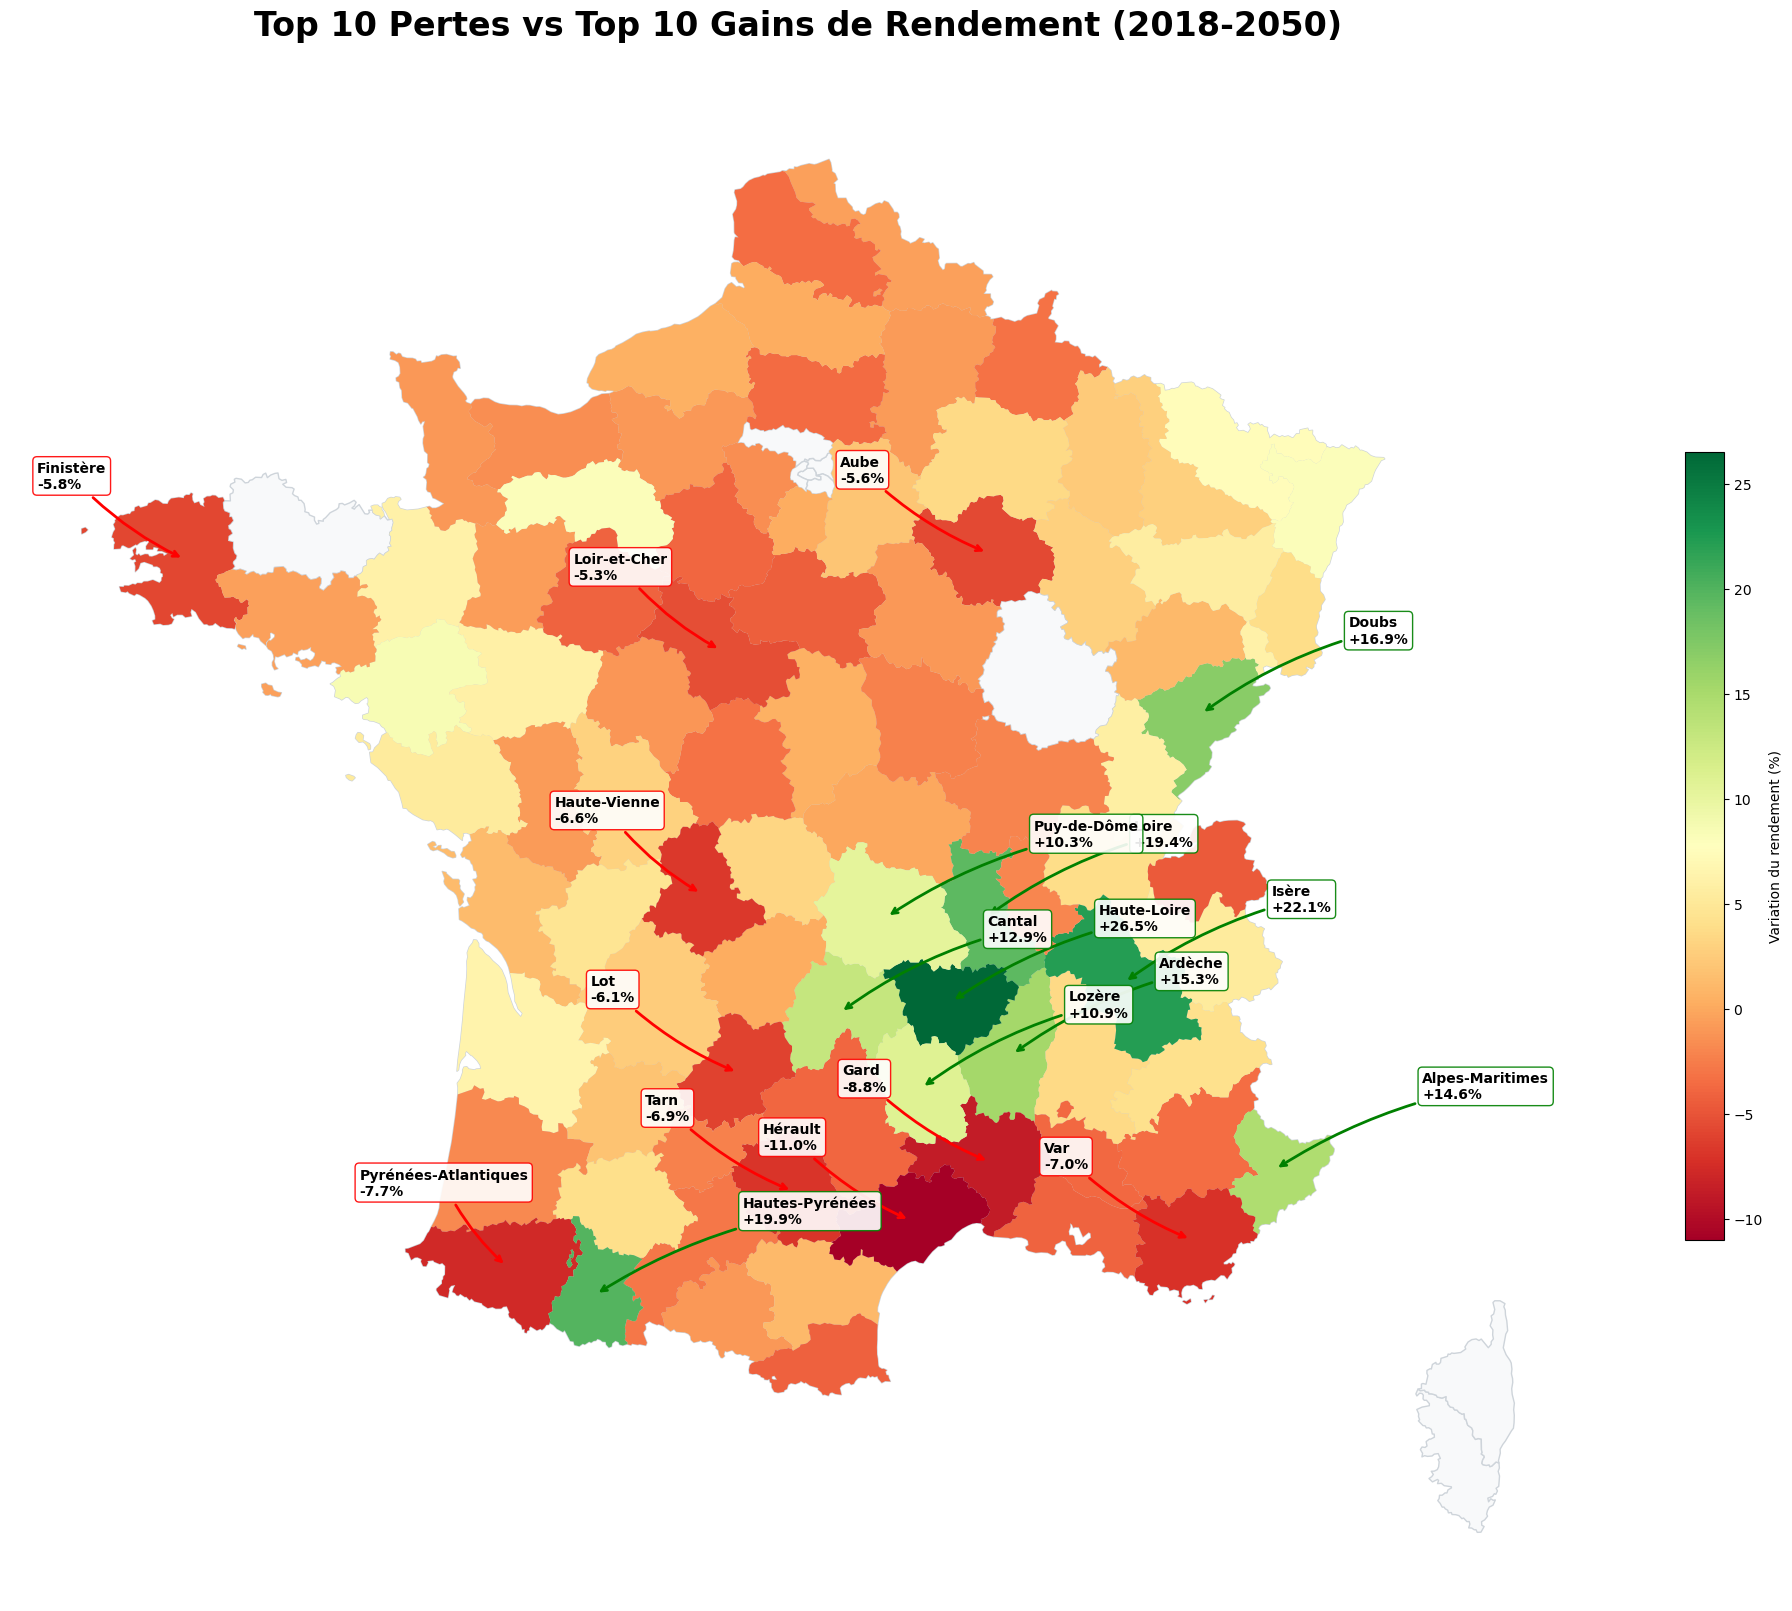

In [183]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata

# 1. Fonction de nettoyage pour garantir le lien (merge)
def normalize(text):
    if not isinstance(text, str): return ""
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text.lower().replace('_', '').replace('-', '').replace(' ', '')

# 2. Chargement du fond de carte (GeoJSON France)
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(url)
france_map['match_key'] = france_map['nom'].apply(normalize)

# 3. Préparation de tes données (On utilise tes résultats de prédiction)
# On suppose que 'comparison' contient les résultats de ton Random Forest
comp_map = comparison.copy()
comp_map['match_key'] = comp_map.index.map(normalize)
merged = france_map.merge(comp_map, on='match_key', how='left')

# 4. SÉLECTION RIGOUREUSE DES 20 EXTRÊMES
# Les 10 plus négatifs (Pertes maximales : -9%, -8%...)
top_10_neg = merged.sort_values(by='change_pct', ascending=True).head(10)

# Les 10 plus positifs (Gains maximaux : +17%, +15%...)
top_10_pos = merged.sort_values(by='change_pct', ascending=False).head(10)

# 5. Création de la Carte
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Fond de carte global
france_map.plot(ax=ax, color='#f8f9fa', edgecolor='#ced4da')

# Coloration (Dégradé Rouge-Jaune-Vert)
merged.plot(column='change_pct', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Variation du rendement (%)", 'shrink': 0.4})

# FONCTION D'ANNOTATION (Flèches et Labels)
def annotate_map(data, color, side='left'):
    for idx, row in data.iterrows():
        centroid = row['geometry'].centroid
        x, y = centroid.x, centroid.y
        
        # Positionnement du texte (alternance gauche/droite pour la lisibilité)
        off_x = -1.5 if side == 'left' else 1.5
        label = f"{row['nom']}\n{row['change_pct']:+.1f}%"
        
        ax.annotate(label, xy=(x, y), xytext=(x + off_x, y + 0.5),
                    arrowprops=dict(arrowstyle="->", color=color, lw=2, connectionstyle="arc3,rad=0.1"),
                    fontsize=10, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.9))

# On ajoute les 10 flèches rouges pour les pertes (à gauche)
annotate_map(top_10_neg, 'red', side='left')

# On ajoute les 10 flèches vertes pour les gains (à droite)
annotate_map(top_10_pos, 'green', side='right')

ax.set_title("Top 10 Pertes vs Top 10 Gains de Rendement (2018-2050)", fontsize=24, fontweight='bold', pad=40)
ax.axis('off')

plt.tight_layout()
plt.show()

Type de flècheOù elles vont se regrouper logiquement ?Pourquoi ?R

ouges (Pertes)Sud-Ouest & Méditerranée (Hérault, Pyrénées, Tarn, Gers).C'est là que le modèle voit le plus de dry_days (jours secs) et d' extreme_heat.


Vertes (Gains)Massif Central & Alpes (Isère, Haute-Loire, Lozère) et Bretagne/Normandie.Le réchauffement y est "utile" : il permet à l'orge de pousser plus vite sans griller (températures plus clémentes en altitude).

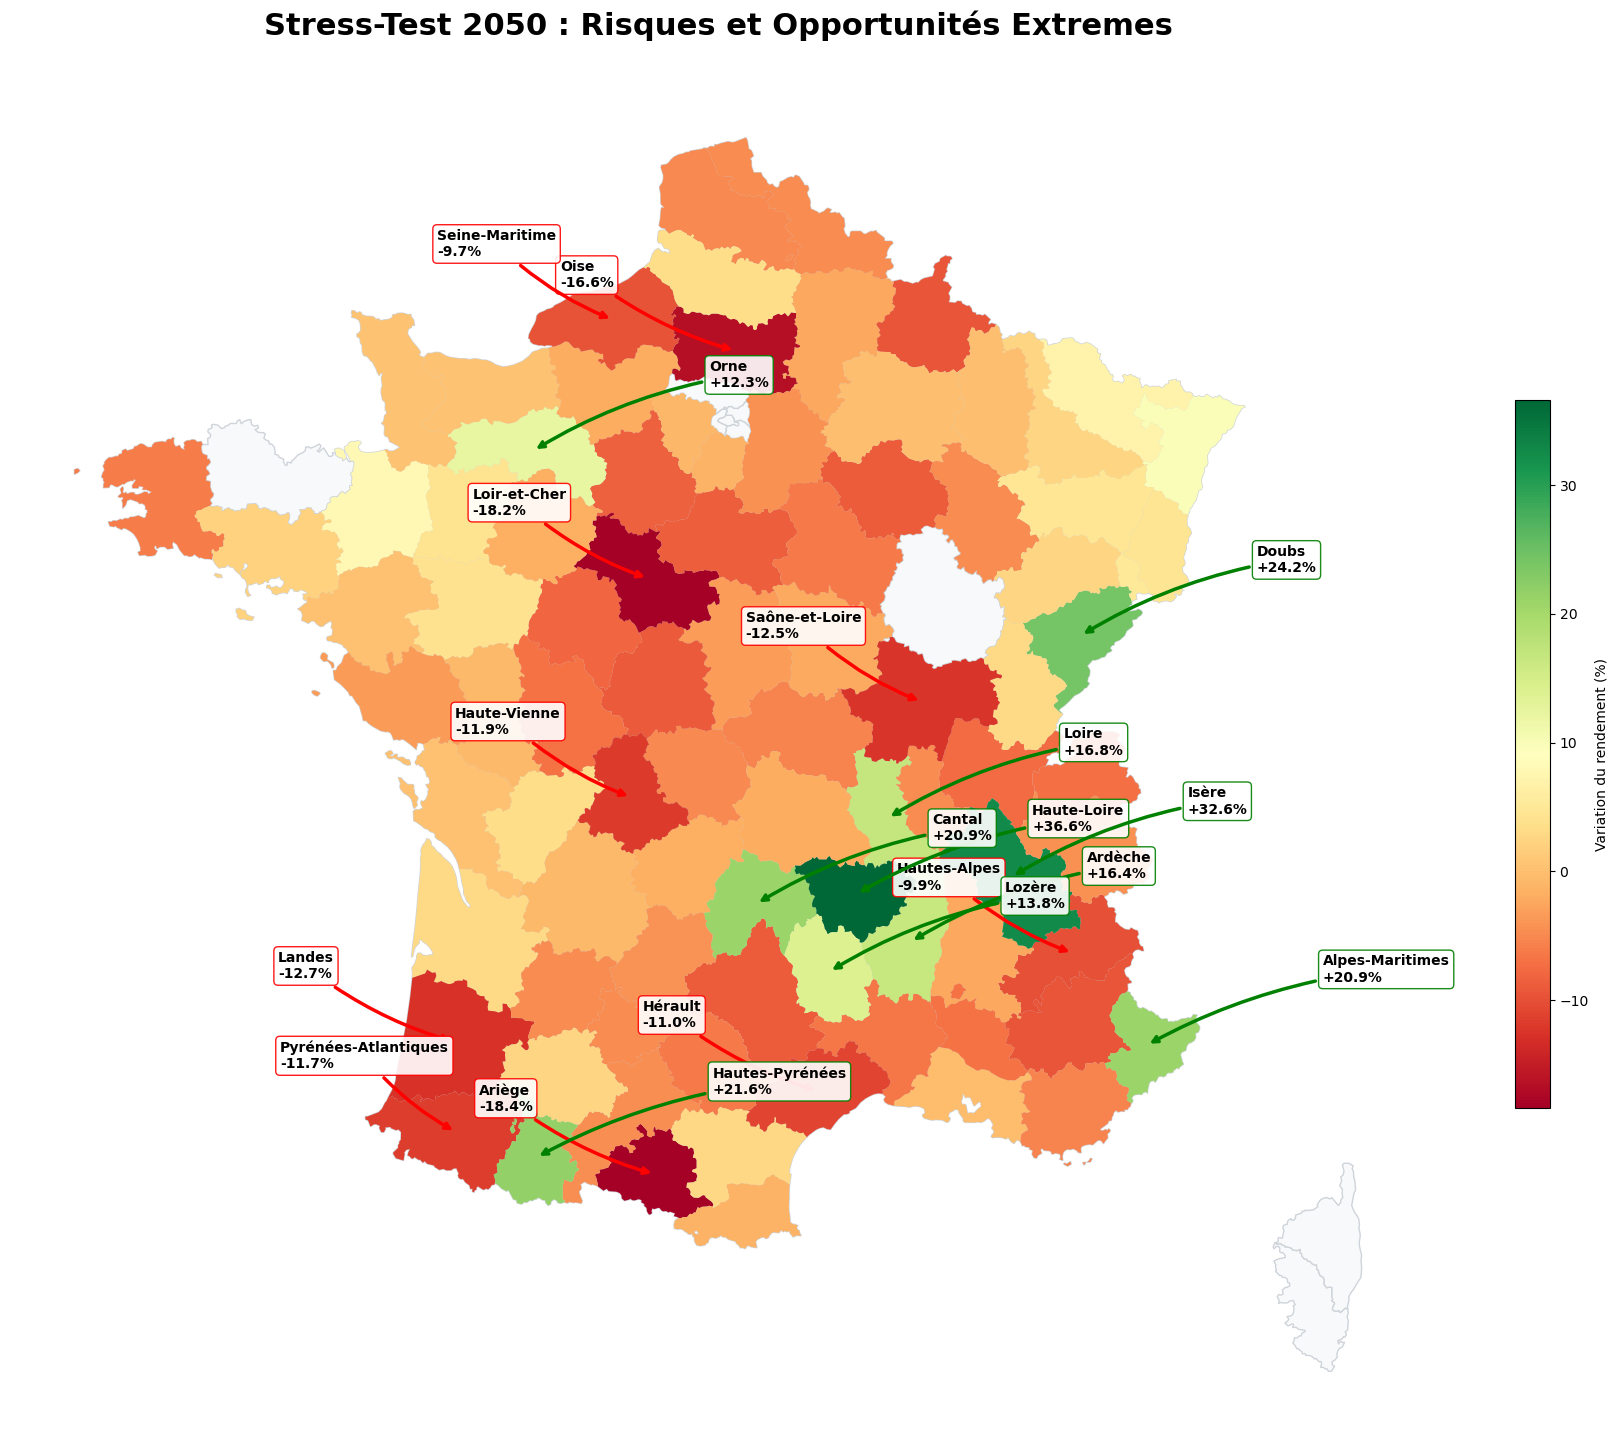

In [179]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata

# 1. Normalisation des noms pour le merge
def normalize_name(text):
    if not isinstance(text, str): return ""
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text.lower().replace('_', '').replace('-', '').replace(' ', '')

# 2. Chargement du fond de carte
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(url)
france_map['match_key'] = france_map['nom'].apply(normalize_name)

# 3. TA MÉTHODE : Comparaison Moyenne Début vs Année 2050 Seule
df_scen = df_future[df_future['scenario'] == 'ssp2_4_5'].copy()

# Point de départ stable
y_start = df_scen[df_scen['year'] <= 2018].groupby('nom_dep')['yield_predicted'].mean()

# Point d'arrivée : L'année 2050 seule (pour capturer le pic de risque)
y_2050 = df_scen[df_scen['year'] == 2050].groupby('nom_dep')['yield_predicted'].mean()

comp = pd.DataFrame({'start': y_start, 'end': y_2050})
comp['change_pct'] = (comp['end'] - comp['start']) / comp['start'] * 100
comp['match_key'] = comp.index.map(normalize_name)

# 4. Fusion
merged = france_map.merge(comp, on='match_key', how='left')

# 5. Sélection des 10 extrêmes (Pertes max et Gains max)
top_10_neg = merged.sort_values(by='change_pct', ascending=True).head(10)
top_10_pos = merged.sort_values(by='change_pct', ascending=False).head(10)

# 6. Création de la Carte
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
france_map.plot(ax=ax, color='#f8f9fa', edgecolor='#ced4da')
merged.plot(column='change_pct', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Variation du rendement (%)", 'shrink': 0.4})

# Fonction pour placer les flèches
def add_labels(data, color, side='left'):
    for idx, row in data.iterrows():
        centroid = row['geometry'].centroid
        x, y = centroid.x, centroid.y
        off_x = -2.0 if side == 'left' else 2.0 # Décalage pour la lisibilité
        
        label = f"{row['nom']}\n{row['change_pct']:+.1f}%"
        
        ax.annotate(label, xy=(x, y), xytext=(x + off_x, y + 0.5),
                    arrowprops=dict(arrowstyle="->", color=color, lw=2.5, connectionstyle="arc3,rad=0.1"),
                    fontsize=10, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.9))

# Ajout des 10 flèches pour les pertes (incluant l'Oise)
add_labels(top_10_neg, 'red', side='left')

# Ajout des 10 flèches pour les gains
add_labels(top_10_pos, 'green', side='right')

ax.set_title("Stress-Test 2050 : Risques et Opportunités Extremes", fontsize=22, fontweight='bold', pad=30)
ax.axis('off')

plt.tight_layout()
plt.show()


Je vais être très direct : on compare bien la productivité de ton orge (le rendement), mais on le fait de deux manières différentes.

Imagine que tu gères un champ d'orge dans l'Oise :

1. Ton premier bloc (year >= 2045) : La "Moyenne de Production"
Ici, tu compares le rendement moyen actuel à ce que tu récolteras en moyenne sur 10 ans en 2050.

Le concept : On sait qu'il y aura des bonnes et des mauvaises récoltes. On veut savoir si, sur le long terme, la terre de l'Oise reste fertile.

Le chiffre : Tu obtiendras peut-être -3%. C'est le "climat" : la baisse est lente mais certaine.

2. Ton deuxième bloc (year == 2050) : La "Récolte Catastrophe"
Ici, tu compares ta moyenne actuelle à la récolte d'une année précise (2050).

Le concept : C'est un scénario de crise. Le modèle simule une année noire (grosse sécheresse en 2050). Tu veux savoir quel est le "trou" maximum dans ton budget si la météo se déchaîne cette année-là.

Le chiffre : Tu obtiens -12%. C'est la "météo" : un accident industriel ponctuel.

En résumé, tu compares :
Méthode	Ce que tu mesures réellement	Résultat pour l'Oise
Moyenne (>= 2045)	La perte de valeur structurelle de tes terres.	Baisse modérée (On s'adapte).
Année Seule (== 2050)	Le risque de rupture de stock sur une année de crise.	Baisse violente (On panique).
Laquelle est la bonne ?
Les deux ! Mais pour ton entreprise :

Si tu parles aux Acheteurs, utilise la moyenne (pour négocier les prix sur 10 ans).

Si tu parles aux Gestionnaires de Risques, utilise l'année 2050 seule (pour prévoir des stocks de secours en cas de crash).

C'est pour ça que tes résultats ne sont pas les mêmes : l'un regarde la santé globale du champ, l'autre regarde le risque de tout perdre sur un seul coup de chaud.

FAIRE LA PRODUCTION PLUTOT COMME ELLE AVAIT DIT?

À l'aveugle, si l'on oublie tes données un instant pour se baser uniquement sur l'agronomie et la climatologie française, voici la carte "logique" que n'importe quel expert s'attendrait à voir pour l'orge d'ici 2050 :1. La "Zone de Danger" (Le Sud)Logiquement, tu dois avoir des pertes significatives dans un croissant qui va du Sud-Ouest à la Méditerranée.Pourquoi ? L'orge est une plante qui déteste les "coups de chaud" pendant le remplissage du grain (mai/juin). Dans le Sud, l'augmentation des températures va avancer la date de récolte, mais surtout "échauder" le grain.Résultats attendus : Entre -5% et -15% de rendement.Départements clés : Hérault, Gard, Haute-Garonne, Tarn, Gers.2. Les "Nouveaux El Dorado" (L'Altitude)C'est le résultat le plus logique et pourtant le plus surprenant.Pourquoi ? Dans des zones comme le Massif Central ou les Alpes, le facteur limitant historique était le froid et une saison de pousse trop courte. Avec le réchauffement, ces zones deviennent thermiquement idéales. La plante y pousse mieux et plus longtemps sans subir les canicules extrêmes des plaines.Résultats attendus : Des hausses fortes, entre +10% et +20%.Départements clés : Isère, Haute-Loire, Lozère, Cantal.3. Le "Bassin de Résilience" (Le Nord et l'Ouest)Pourquoi ? La Normandie, la Bretagne et les Hauts-de-France bénéficient de l'influence océanique qui tempère les canicules. Tant qu'il y a de l'eau, le rendement se maintient, voire progresse légèrement car l'augmentation du $CO_2$ dans l'air booste un peu la photosynthèse (effet fertilisant du carbone).Résultats attendus : Stabilité ou légère hausse (-2% à +5%).Départements clés : Somme, Pas-de-Calais, Calvados, Ille-et-Vilaine.

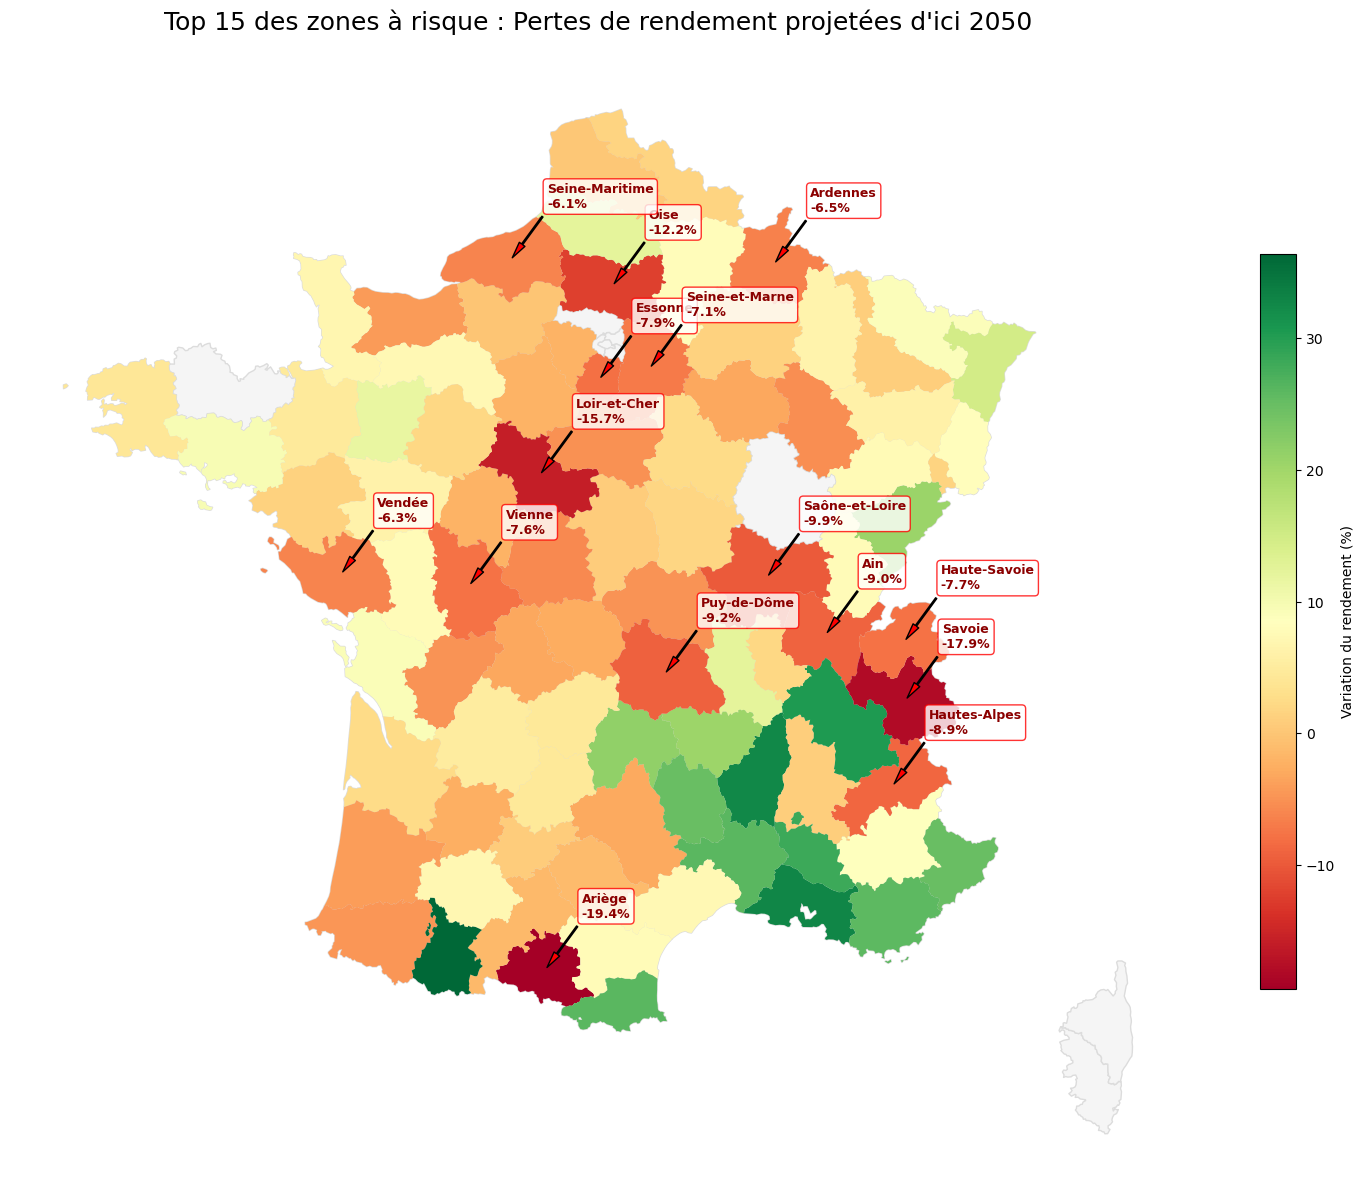

In [175]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata

# 1. Fonction de nettoyage pour que le merge fonctionne à 100%
def normalize(text):
    if not isinstance(text, str): return ""
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text.lower().replace('_', '').replace('-', '').replace(' ', '')

# 2. Chargement du fond de carte
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(url)
france_map['match_key'] = france_map['nom'].apply(normalize)

# 3. Préparation de tes données de variation (Basé sur tes calculs précédents)
# On part de ton dataframe 'comparison' qui contient déjà 'change_pct'
# Si tu ne l'as plus, on le recalcule vite :
df_2050 = df_future[(df_future['scenario'] == 'ssp2_4_5') & (df_future['year'] == 2050)]
y_start = df_future[df_future['year'] <= 2020].groupby('nom_dep')['yield_predicted'].mean()
y_end = df_2050.groupby('nom_dep')['yield_predicted'].mean()

comp = pd.DataFrame({'start': y_start, 'end': y_end})
comp['change_pct'] = (comp['end'] - comp['start']) / comp['start'] * 100
comp['match_key'] = comp.index.map(normalize)

# 4. Fusion avec la carte
merged = france_map.merge(comp, on='match_key', how='left')

# 5. Identifier les 15 zones avec la perte la plus forte (les plus négatives)
top_losses = merged.sort_values(by='change_pct').head(15)

# 6. Création de la Carte
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Fond de carte global (en gris clair)
france_map.plot(ax=ax, color='#f5f5f5', edgecolor='#dcdcdc')

# Coloration des zones impactées (en dégradé de rouge)
merged.plot(column='change_pct', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Variation du rendement (%)", 'shrink': 0.5})

# AJOUT DES FLÈCHES ET DES VALEURS POUR LE TOP 15
for idx, row in top_losses.iterrows():
    # Coordonnées du centre du département
    centroid = row['geometry'].centroid
    x, y = centroid.x, centroid.y
    
    # Texte de l'étiquette
    label = f"{row['nom']}\n{row['change_pct']:.1f}%"
    
    # On place le texte un peu à côté avec une flèche qui pointe le centre
    ax.annotate(label, xy=(x, y), xytext=(x+0.5, y+0.5),
                arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5),
                fontsize=9, fontweight='bold', color='darkred',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

ax.set_title("Top 15 des zones à risque : Pertes de rendement projetées d'ici 2050", fontsize=18, pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()